In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-10-31 21:21:35--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.167.32, 52.217.205.64, 54.231.134.112, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.167.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  48.7MB/s    in 0.3s    

2023-10-31 21:21:35 (48.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
   data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [7]:
import numpy as np
from tensorflow import keras

# Supongamos que tienes tus datos de temperatura en un array llamado 'temperature'.

# Define la longitud de las secuencias y el retraso (delay)
sequence_length = 120  # Longitud de las secuencias
delay = 10  # Número de pasos en el futuro para predecir la temperatura

# Configura otras variables
sampling_rate = 1  # Tasa de muestreo (cada 10 minutos)
batch_size = 32  # Tamaño del lote
num_train_samples = int(len(temperature)/2)  # Número de muestras de entrenamiento
num_val_samples = int(len(temperature)/4)  # Número de muestras de validación

# Crea el conjunto de datos de series temporales
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)


train_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
    end_index=len(temperature)-sequence_length)




In [16]:
from tensorflow import keras
from tensorflow.keras import layers

# Construir el modelo
model = keras.Sequential()
ks = 10
model.add(layers.Conv1D(filters=32,kernel_size=ks, padding='causal', dilation_rate=1, input_shape=(None, 1)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(filters=32,kernel_size=ks, padding='causal', dilation_rate=2))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(filters=32,kernel_size=ks, padding='causal', dilation_rate=4))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

# Compilar el modelo
model.summary()
model.compile(optimizer='adam', loss='mse')


# Entrenar el modelo
history = model.fit(train_dataset, epochs=15, validation_data=val_dataset)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, None, 32)          352       
                                                                 
 max_pooling1d_12 (MaxPooli  (None, None, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_19 (Conv1D)          (None, None, 32)          10272     
                                                                 
 max_pooling1d_13 (MaxPooli  (None, None, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_20 (Conv1D)          (None, None, 32)          10272     
                                                                 
 global_max_pooling1d_6 (Gl  (None, 32)               

In [ ]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay], #notar que ahora la serie en x son las demás columnas de los datos
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)



In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']


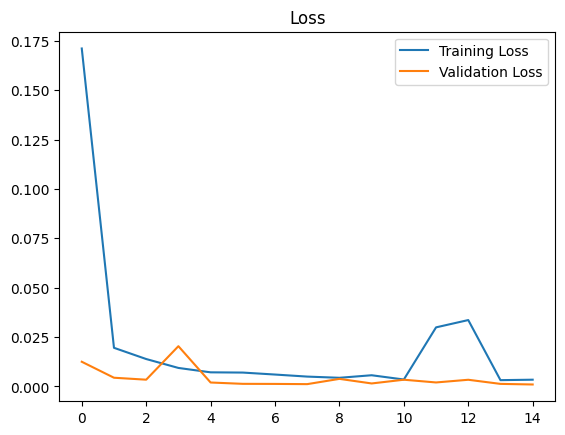

In [18]:
import matplotlib.pyplot as plt

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()
